# Spark Exploration Exercises

These exercises should go in a notebook or script named explore.

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl
import datetime

import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

import wrangle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# create spark session
spark = SparkSession.builder.getOrCreate()

In [3]:
case_df = spark.read.csv("case.csv", header=True, inferSchema=True)
dept_df = spark.read.csv("dept.csv", header=True, inferSchema=True)
source_df = spark.read.csv("source.csv", header=True, inferSchema=True)

df = wrangle.wrangle_311(case_df, dept_df, source_df)

In [4]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 zipcode              | 78207                
 case_age             | 1317                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 source_username      | svcCRMLS             
only showing top 1 row



### 1. How many different cases are there, by department?

In [5]:
# first method get aggregate from spark then graph with pandas

df.groupby('department').count().show(truncate=False)

+------------------------+------+
|department              |count |
+------------------------+------+
|Solid Waste             |286287|
|Animal Care Services    |119362|
|Trans & Cap Improvements|97841 |
|Parks & Recreation      |19964 |
|Customer Service        |2889  |
|Metro Health            |5313  |
|City Council            |34    |
|DSD/Code Enforcement    |323579|
+------------------------+------+



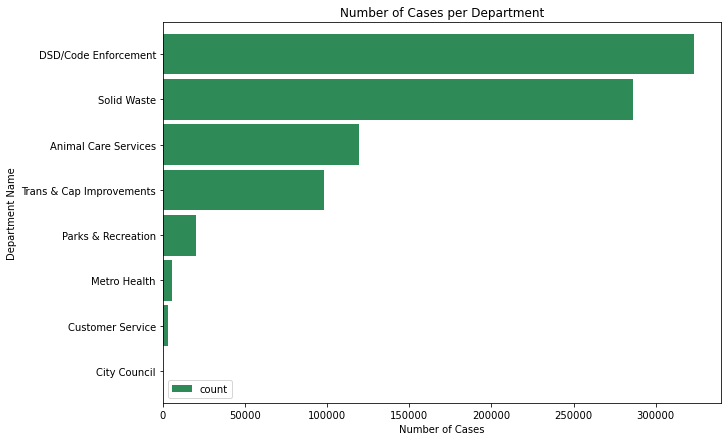

In [6]:
(
    df.groupby('department').count()
    .toPandas()
    .set_index('department')
    .sort_values(by = 'count', ascending = True)
    .plot.barh(color = 'seagreen', figsize = (10,7), width = .9)
)

plt.title('Number of Cases per Department')
plt.xlabel('Number of Cases')
plt.ylabel('Department Name')
plt.show()

### 2. Does the percentage of cases that are late vary by department?
- yes it does, Customer Service has the highest amount of late cases by percentage
- City Council has the lowest percentage of late cases (0%) but it only has 34 total cases
- Second lowest percentage is Trans & Cap improvements


In [7]:
# aggregate in Spark. 
# find percentages of late cases. Stacked Bar Graph

df.groupby('department').pivot('case_late').count().fillna(0).show()

+--------------------+------+-----+
|          department| false| true|
+--------------------+------+-----+
|         Solid Waste|252558|33729|
|Animal Care Services| 95611|23751|
|Trans & Cap Impro...| 92312| 5529|
|    Customer Service|   854| 2035|
|  Parks & Recreation| 16154| 3810|
|        Metro Health|  4459|  854|
|        City Council|    34|    0|
|DSD/Code Enforcement|297140|26439|
+--------------------+------+-----+



In [8]:
# Finding all the late cases
late_cases = df.groupby('department').pivot('case_late').count().fillna(0)

In [9]:
# practice adding an all column for later percentage calculation
# total counts
late_cases.withColumn('all', ( col('true') + col('false')) ).show()

+--------------------+------+-----+------+
|          department| false| true|   all|
+--------------------+------+-----+------+
|         Solid Waste|252558|33729|286287|
|Animal Care Services| 95611|23751|119362|
|Trans & Cap Impro...| 92312| 5529| 97841|
|    Customer Service|   854| 2035|  2889|
|  Parks & Recreation| 16154| 3810| 19964|
|        Metro Health|  4459|  854|  5313|
|        City Council|    34|    0|    34|
|DSD/Code Enforcement|297140|26439|323579|
+--------------------+------+-----+------+



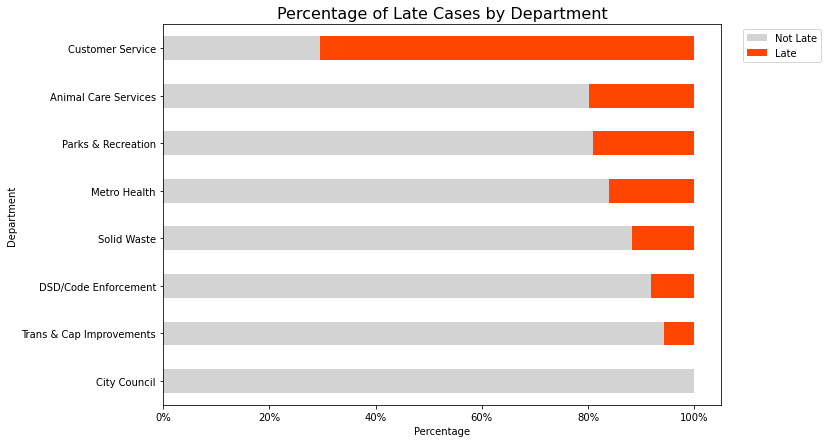

In [10]:
(
    # groupby Department
    df.groupby('department')
    
    # pivot on case late and count
    .pivot('case_late').count()
    .fillna(0)
    
    # create the all column
    .withColumn('all', col('true') + col('false') )
    
    # convert to pandas
    .toPandas()
    
    # set index to department for graphability
    .set_index('department')
    
    # apply function that calculates percentage for each row
    .apply(lambda row: row / row['all'], axis = 1)
    
    # drop the all column
    .drop(columns = 'all')
    
    # sort so highest percent late is at top
    .sort_values(by = 'true')
    
    # plot as horizontal bar chart with custom colors
    .plot.barh(stacked = True, figsize = (10,7), color = ['lightgrey', 'orangered'])
)

# relable legend
plt.legend(labels = ['Not Late', 'Late'], bbox_to_anchor = ((1.03, 1)))
plt.title('Percentage of Late Cases by Department', fontsize = 16)
plt.xlabel('Percentage')
plt.ylabel('Department')
# set x tick lables to percentage format
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))

plt.show()

### 3. On average, how late are the late cases by department?


In [11]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show()
)

+--------------------+------------------+
|          department|     avg_days_late|
+--------------------+------------------+
|    Customer Service| 88.18248182589822|
|DSD/Code Enforcement|49.506339986350454|
|Animal Care Services|  23.4467296347382|
|  Parks & Recreation|22.427807192724135|
|Trans & Cap Impro...|10.662950455078674|
|         Solid Waste|7.1471727895574135|
|        Metro Health| 6.494699602827871|
+--------------------+------------------+



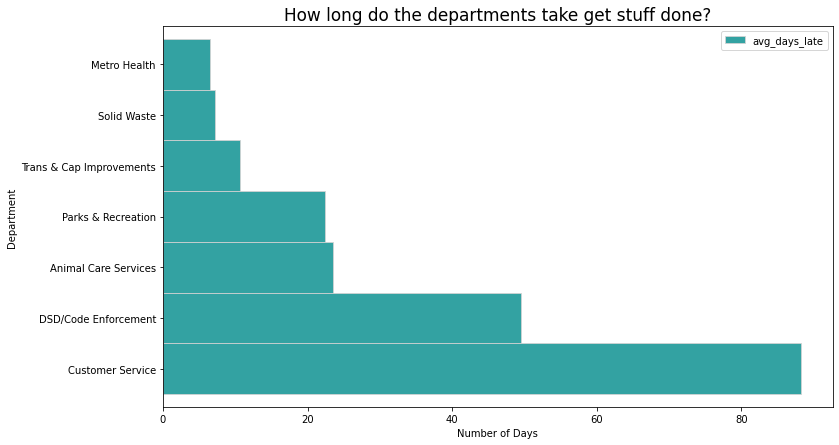

In [12]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('department')
    .plot.barh(width = 1, ec = 'lightgrey', alpha = .8, color = 'darkcyan', figsize = (12,7))
)
plt.title("How long do the departments take get stuff done?", fontsize = 17)
plt.xlabel("Number of Days")
plt.ylabel("Department")
plt.show()

### 4. What is the service type that is the most late? Just for Parks & Rec?
- Zoning: Recycle Yards and Zoning: Junk yards
- For parks and rec : Amenity park improvement and Major park improvement install

In [13]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)


+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



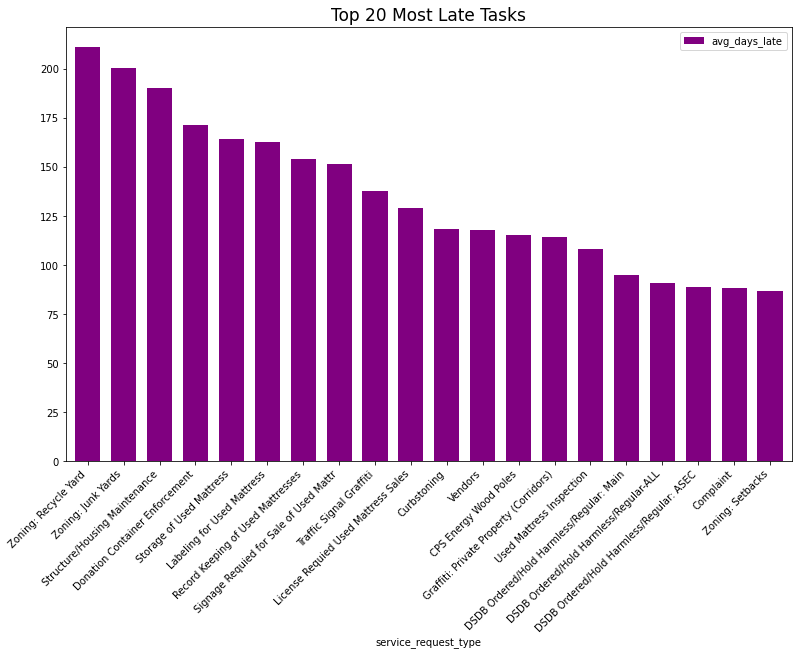

In [14]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.bar(figsize = (13,8), width = .7, color = 'purple')
)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Top 20 Most Late Tasks', fontsize = 17)
plt.show()

In [15]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...| 76.60603677123078|
|Major Park Improv...| 75.79450367282354|
|Reservation Assis...|       66.03116319|
|Park Building Mai...|59.367469802695666|
| Sportfield Lighting|52.034858419575656|
|          Electrical|42.951971658345116|
|        Tree Removal| 40.28404224560715|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253488|
+--------------------+------------------+
only showing top 10 rows



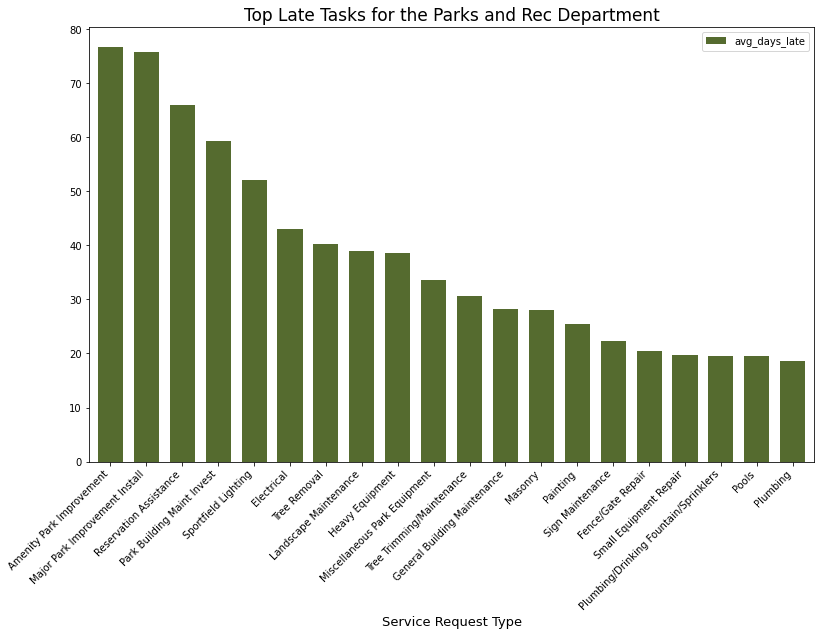

In [16]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.bar(figsize = (13,8), width = .7, color = 'darkolivegreen')
)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Service Request Type', fontsize = 13)
plt.title('Top Late Tasks for the Parks and Rec Department', fontsize = 17)
plt.show()

### 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.


In [17]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(truncate = False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |66403|
|Bandit Signs                          |32968|
|Front Or Side Yard Parking            |28920|
|Junk Vehicle On Private Property      |21649|
|Alley-Way Maintenance                 |20293|
|Right Of Way/Sidewalk Obstruction     |17836|
|Vacant Lot/Overgrown/Trash            |9497 |
|Minimum Housing-Owner Occupied        |8617 |
|Graffiti: Private Property (Corridors)|8525 |
|Minimum Housing-Tenant Occupied       |8104 |
|Dang. Premises/CL/SEC                 |8004 |
|"Vacant Lot-Private (12"")"           |7875 |
|Brush Violations                      |7530 |
|Permits Building                      |6950 |
|Vacant House Overgrown Yard           |6278 |
|Graffiti: Building                    |4572 |
|Low Hanging Limbs on Streets/Sidewalk |4107 |
|Graffiti Public Property              |4104 |
|CPS Energy W

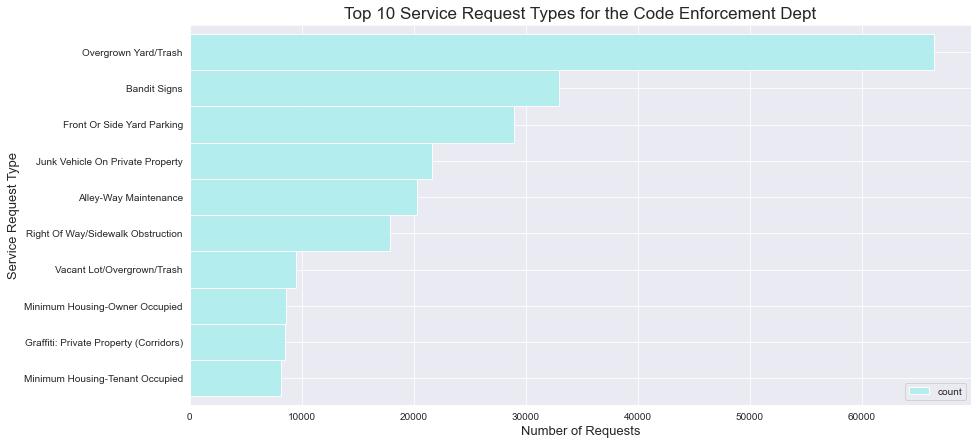

In [18]:
with sns.axes_style('darkgrid'):
    
    (
        df.filter(col('department') == 'DSD/Code Enforcement')
        .groupby('service_request_type').count()
        .sort(desc('count'))
        .toPandas()
        .set_index('service_request_type')
        .head(10)
        .sort_values(by = 'count', ascending = True)
        .plot.barh(figsize = (14,7), color = 'paleturquoise', width = 1, ec = 'white', alpha = .9)
    )
    plt.title('Top 10 Service Request Types for the Code Enforcement Dept', fontsize = 17)
    plt.xlabel('Number of Requests', fontsize = 13)
    plt.ylabel('Service Request Type', fontsize = 13)
    plt.show()

### 6. Does whether or not its a weekend matter for when a case is opened/closed?
- Look at all the open dates
- look at all the closed dates

In [19]:
# turn datetime to day of the week
df.select(date_format(col("case_opened_date"), "EEEE")).show(5)

+-----------------------------------+
|date_format(case_opened_date, EEEE)|
+-----------------------------------+
|                             Monday|
|                             Monday|
|                             Monday|
|                             Monday|
|                             Monday|
+-----------------------------------+
only showing top 5 rows



In [20]:

df.select(dayofweek('case_opened_date'), date_format(col("case_opened_date"), "EEEE")).show(5)

+---------------------------+-----------------------------------+
|dayofweek(case_opened_date)|date_format(case_opened_date, EEEE)|
+---------------------------+-----------------------------------+
|                          2|                             Monday|
|                          2|                             Monday|
|                          2|                             Monday|
|                          2|                             Monday|
|                          2|                             Monday|
+---------------------------+-----------------------------------+
only showing top 5 rows



In [50]:
# aggrigrate in spark to. get counts
(
    df
    .groupby(date_format(col("case_opened_date"), "EEEE").alias('weekday_open'),
             dayofweek(col('case_opened_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .show()
)

+------------+------------+------+
|weekday_open|numbered_day| count|
+------------+------------+------+
|      Sunday|           1| 29343|
|      Monday|           2|155781|
|     Tuesday|           3|164608|
|   Wednesday|           4|149783|
|    Thursday|           5|155919|
|      Friday|           6|145242|
|    Saturday|           7| 54593|
+------------+------------+------+



In [22]:
(
    df
    .groupby(date_format(col("case_closed_date"), "EEEE").alias('weekday_closed'),
             dayofweek(col('case_closed_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .show()
)

+--------------+------------+------+
|weekday_closed|numbered_day| count|
+--------------+------------+------+
|        Sunday|           1| 27276|
|        Monday|           2|136994|
|       Tuesday|           3|157360|
|     Wednesday|           4|173833|
|      Thursday|           5|148120|
|        Friday|           6|131026|
|      Saturday|           7| 62327|
+--------------+------------+------+



In [23]:
# turn to pandas for graphing 
open_dates = (
    df
    .groupby(date_format(col("case_opened_date"), "EEEE").alias('weekday'),
             dayofweek(col('case_opened_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .toPandas()
)
open_dates

,weekday,numbered_day,count
0,Sunday,1,29343
1,Monday,2,155781
2,Tuesday,3,164608
3,Wednesday,4,149783
4,Thursday,5,155919
5,Friday,6,145242
6,Saturday,7,54593


In [24]:
closed_dates = (
    df
    .groupby(date_format(col("case_closed_date"), "EEEE").alias('weekday'),
             dayofweek(col('case_closed_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .toPandas()
)

In [25]:
# merge two tables together
all_dates = open_dates.merge(closed_dates, how = 'left', on = 'weekday')

#drop numbered_day
all_dates = all_dates.drop(columns = ['numbered_day_x', 'numbered_day_y'])


# set index to weekday and rename columns for clarity
all_dates = all_dates.set_index('weekday').rename(columns = {'count_x': 'opened_days', 'count_y': 'closed_days'})

# drop nulls, that's from cases not being closed yet
#all_dates = all_dates.dropna()

all_dates

,opened_days,closed_days
weekday,,
Sunday,29343,27276
Monday,155781,136994
Tuesday,164608,157360
Wednesday,149783,173833
Thursday,155919,148120
Friday,145242,131026
Saturday,54593,62327


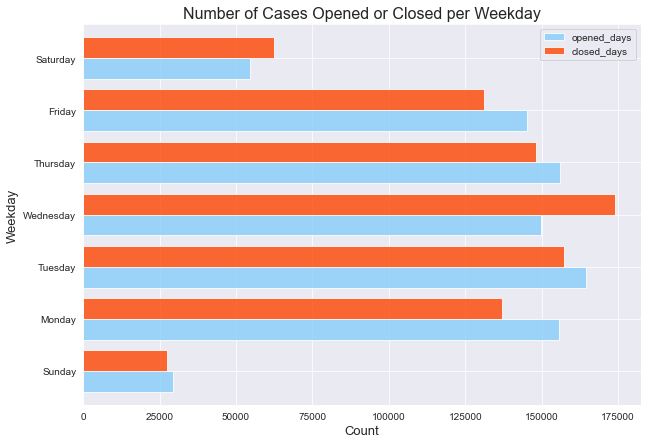

In [26]:
with sns.axes_style('darkgrid'):
    
    all_dates.plot.barh(figsize = (10,7), color = ['lightskyblue', 'orangered'], width = .8, alpha = .8)
    plt.title('Number of Cases Opened or Closed per Weekday', fontsize = 16)
    plt.xlabel('Count', fontsize = 13)
    plt.ylabel('Weekday', fontsize = 13)
    plt.show()

### 7. On average, how many cases are opened a day for the Customer Service department?


In [58]:
# aggrigate for average for daily case opening

(
    df
    .filter(col('department') == 'Customer Service')
    .groupby(col('case_opened_date'))
    .count()
    .select(mean('count'))
    .show()
)


+------------------+
|        avg(count)|
+------------------+
|1.0201271186440677|
+------------------+



On Average, The customer service Department opens 1 case per day (if they do have a case that day). Seems like if they do open a case they rarely open more than one on a day.
Average for all days is probably lower. This data only includes dates where a customer service case is opened.

In [75]:
(
    df
    .groupby(col('case_opened_date'), col('department'))
    .count()
    .groupby(col('department'))
    .avg('count')
    .show(truncate = False)
)

+------------------------+------------------+
|department              |avg(count)        |
+------------------------+------------------+
|Solid Waste             |1.5374168291150456|
|Animal Care Services    |1.172537770879585 |
|Trans & Cap Improvements|1.1817259496346397|
|Parks & Recreation      |1.0504051352204566|
|Customer Service        |1.0201271186440677|
|Metro Health            |1.0436063641720683|
|City Council            |1.0303030303030303|
|DSD/Code Enforcement    |1.6638163307280955|
+------------------------+------------------+



### 8. Does the number of service requests for the solid waste department vary by day of the week?

In [27]:
(
    df
    .filter(col('department') == 'Solid Waste')
    .groupby(date_format(col("case_closed_date"), "EEEE").alias('weekday_closed'),
             dayofweek(col('case_closed_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .show()
)

+--------------+------------+-----+
|weekday_closed|numbered_day|count|
+--------------+------------+-----+
|        Sunday|           1| 5326|
|        Monday|           2|41474|
|       Tuesday|           3|46814|
|     Wednesday|           4|68128|
|      Thursday|           5|47137|
|        Friday|           6|43703|
|      Saturday|           7|32053|
+--------------+------------+-----+



In [28]:
solid_waste = (
    df
    .filter(col('department') == 'Solid Waste')
    .groupby(date_format(col("case_opened_date"), "EEEE").alias('weekday'),
             dayofweek(col('case_opened_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .toPandas()
)

In [29]:
# create percentage column by dividing the count by the sum of all the counts
solid_waste['percent'] = solid_waste['count'] / solid_waste['count'].sum()

In [30]:
solid_waste

,weekday,numbered_day,count,percent
0,Sunday,1,7105,0.024818
1,Monday,2,59517,0.207893
2,Tuesday,3,59759,0.208738
3,Wednesday,4,43150,0.150723
4,Thursday,5,48914,0.170857
5,Friday,6,52121,0.182059
6,Saturday,7,15721,0.054913


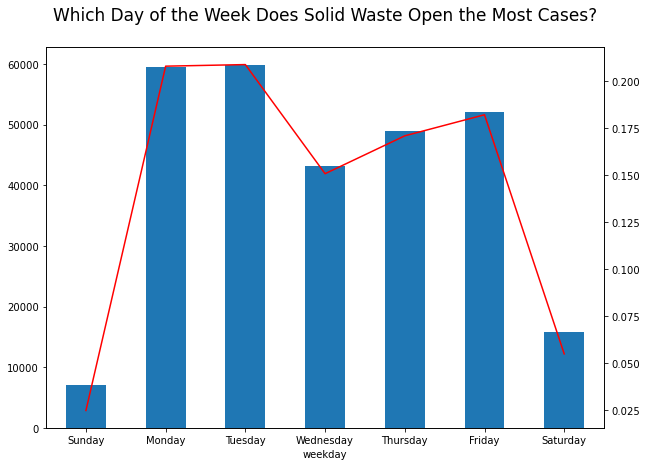

In [31]:
solid_waste.set_index('weekday')['count'].plot(kind='bar', figsize = (10,7))
solid_waste.set_index('weekday')['percent'].plot(secondary_y = True, color = 'red')

plt.title('Which Day of the Week Does Solid Waste Open the Most Cases?\n', fontsize = 17)
plt.show()

In [32]:
colors = ['#85550e', '#5eb6cd', '#a1cc3a', '#a8b3b1' , '#0792a3', '#caac7e', '#ee2f3e', '#9671b0']

colors2 = ['#83485F','#7E5D81','#68769B','#438FA7','#23A5A1','#43B78C','#7CC470','#BBCC57']


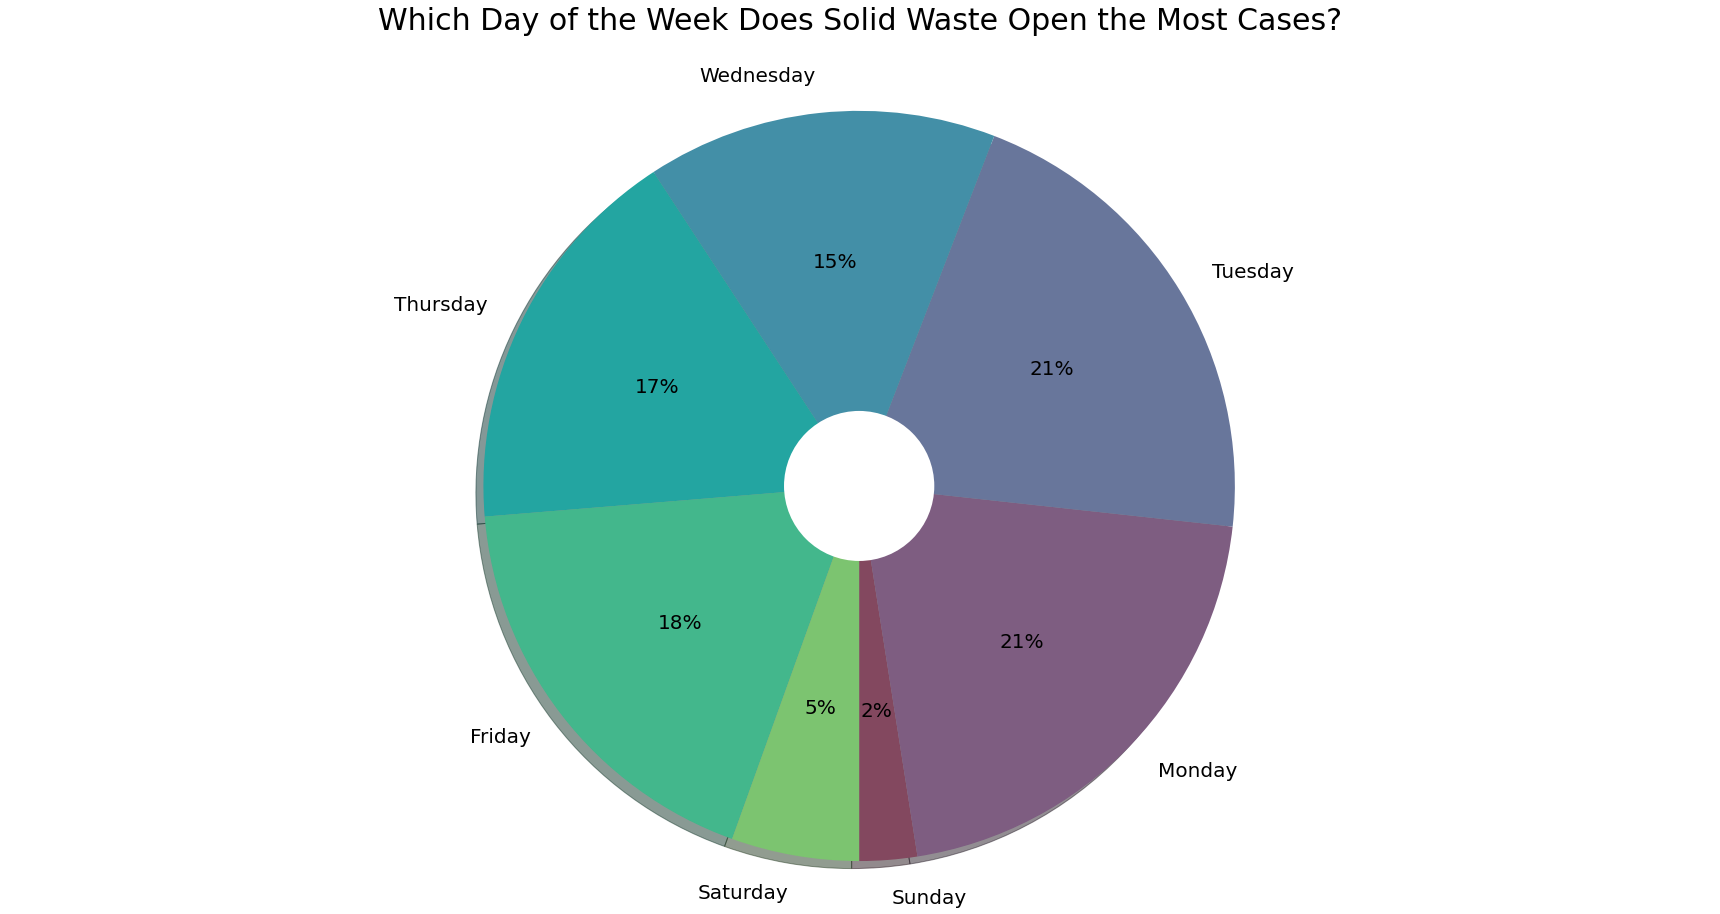

In [33]:
# make pie chart with percentages
fig1, ax1 = plt.subplots(figsize=(24,12))
mypie = ax1.pie(solid_waste['count'], autopct='%.0f%%', shadow=True, colors = colors2,
                labels = solid_waste['weekday'],
                startangle= -90, textprops={'fontsize': 20})

centre_circle = plt.Circle((0,0),0.20,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Which Day of the Week Does Solid Waste Open the Most Cases?\n', fontsize = 30)
plt.show()

In [34]:
import lux

In [36]:
solid_waste

,weekday,numbered_day,count,percent
0,Sunday,1,7105,0.024818
1,Monday,2,59517,0.207893
2,Tuesday,3,59759,0.208738
3,Wednesday,4,43150,0.150723
4,Thursday,5,48914,0.170857
5,Friday,6,52121,0.182059
6,Saturday,7,15721,0.054913


In [ ]:
lux